The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts.

Hence, in this notebook, we will try to visualize the network we used in `CNN_VGG_architeture.ipynb`

Three methods will be covered.
1. Visualizing intermediate convnet outputs (intermediate activations)  
   ==> understanding how successive convnet layers transform their input, 
       and getting a first idea of the meaning of individual convnet filters.
       
2. Visualizing convnets filters
   ==> understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
   
3. Visualizing heatmaps of class activation in an image
   ==> understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.
   


## Visualizing intermediate activations

可视化中间层的激活（输出）

我们可以看到输入如何被分解被Network学习到的不同的过滤器。从三个维度对特征图进行可视化:宽度、高度和深度(通道)

由于每个通道都是相对独立的，因此我们应将每个通道的可视化的特征图单独绘制

In [9]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
from keras.models import load_model
import matplotlib.pyplot as plt
import os, shutil
import cv2
import numpy as np

In [5]:
# Let consider the model constructed for small size dataset (cats and dogs)

model = load_model('cats_and_dogs_small_1.h5')
model.summary()

2021-09-30 14:31:46.620043: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 14:31:46.621679: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 15, 15, 128)      

(1, 150, 150, 3)


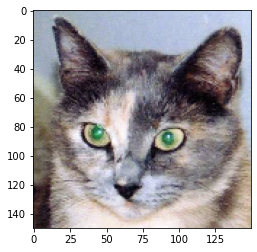

In [11]:
#Input a non-trained images
img_path = '/Users/zhiruitang/Desktop/Deep_Learning\
/Jupyter_Code_DL/Convolution_neural_networks/cats_and_dogs_small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img) # a 4D tensor (1, 150, 150, 3)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. 
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

(1, 148, 148, 32)


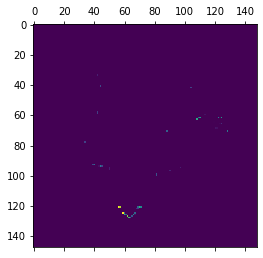

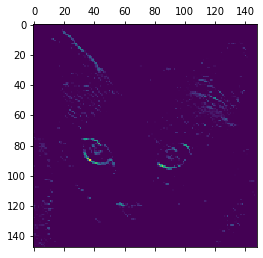

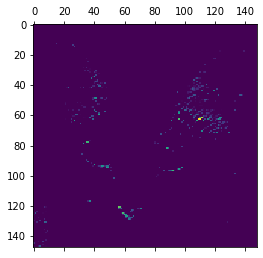

In [29]:
#Instantiating a model from an input tensor and a list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]] #Extracts the outputs of top 8 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) #Creates a model that will return these outputs, given the model input
activations = activation_model.predict(img_tensor) #Returns a list of five Numpy arrays: one array per layer activation

#the activation of the first convolution layer for the cat image input
first_layer_activation = activations[0]
print(first_layer_activation.shape)

# the fourth and seventh channel of the activation of the first layer of the original model
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis') #encode nose
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis') #encode eyes
plt.matshow(first_layer_activation[0, :, :, 8], cmap='viridis')

/opt/anaconda3/envs/keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


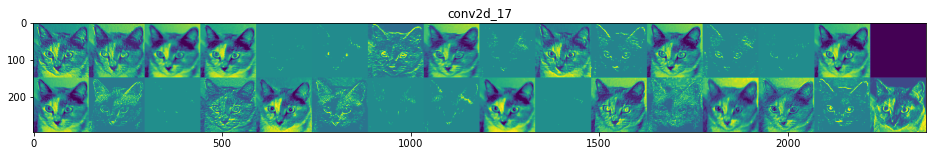

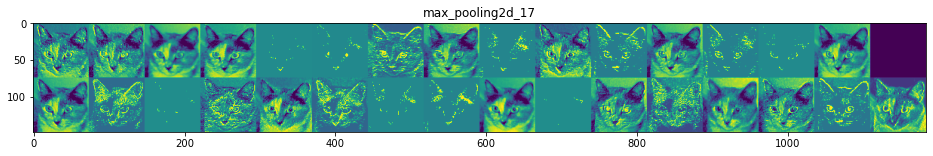

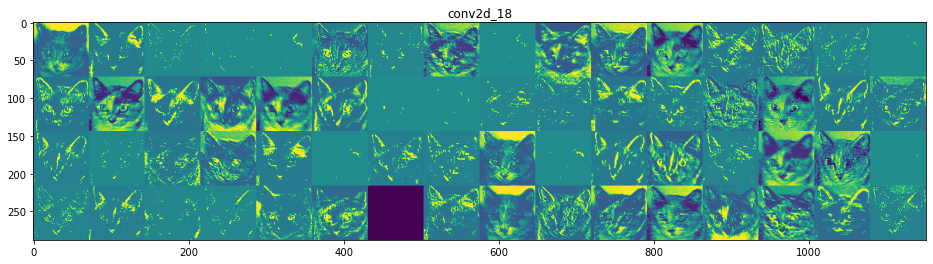

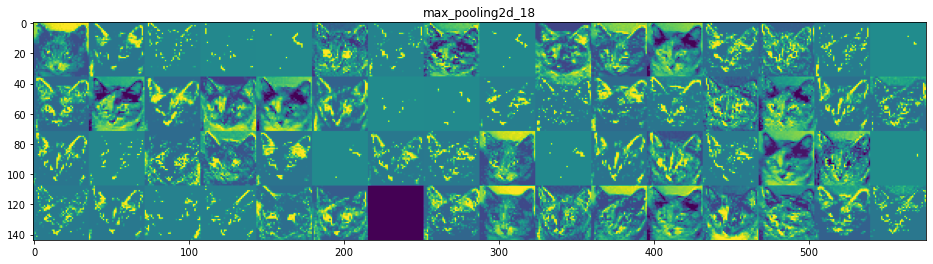

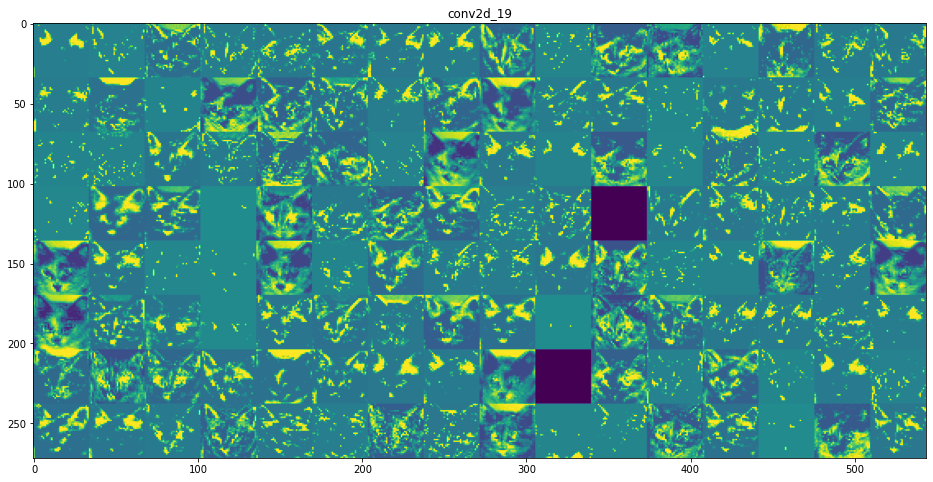

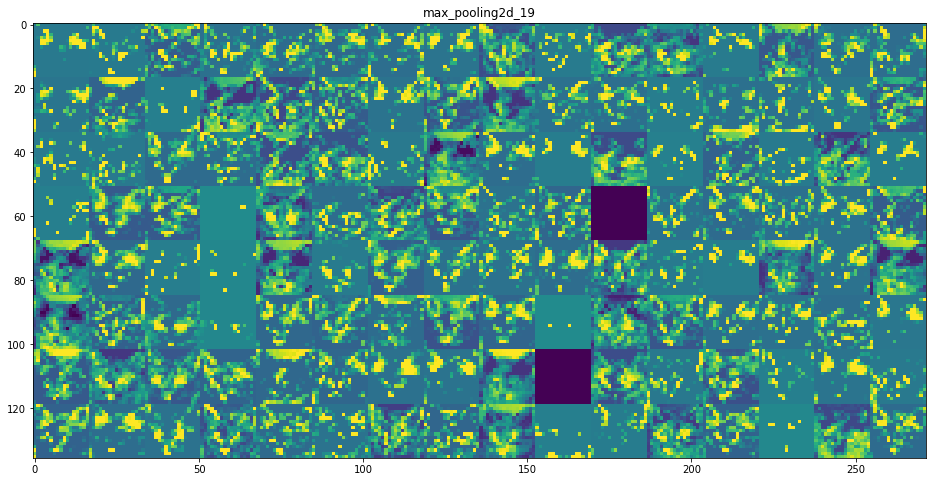

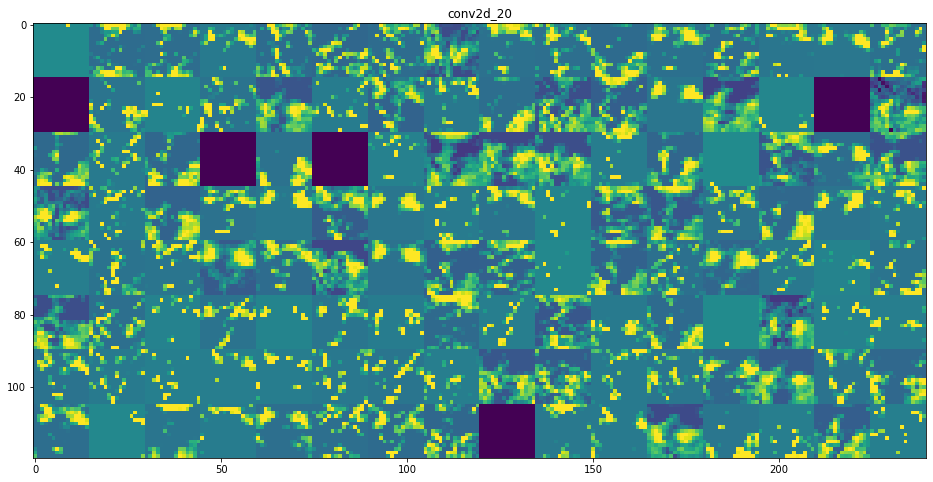

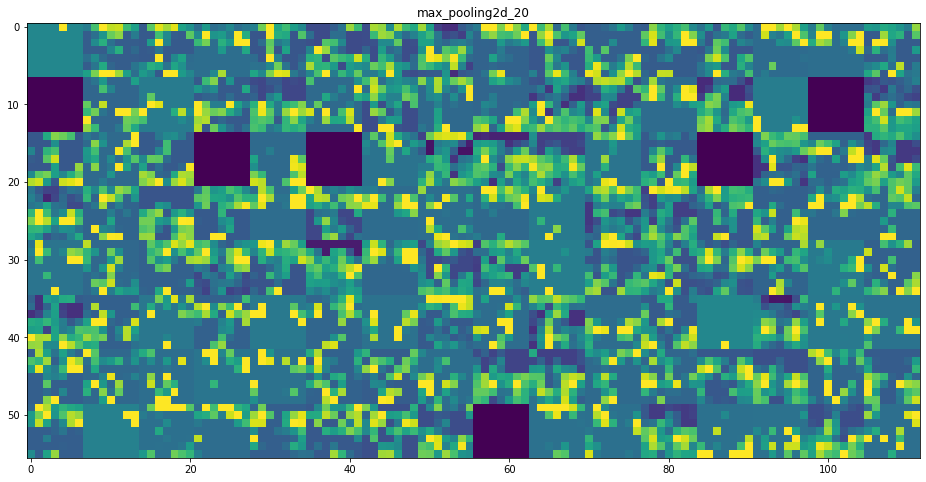

In [30]:
#Visualizing every channel in every intermediate activation
layer_names = [] #names of the layers
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

#Displays the feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1] #Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features)
    
    #Tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
 
    #Tiles each filter into a big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col * images_per_row + row]
            
            #Post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
             
            #Displays the grid
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Conclusion:

卷积神经网络像一个information distillation pipeline. 输入（图片）的信息随着层数的增加变得越来越抽象。

这符合人类的视觉：

1. 第一层像各种的边缘检测（edge detectors）

2. 随着层数增加，这个网络开始编码更higher-level concepts,像猫眼睛，猫耳朵


此外，我们观察到激励的稀疏度（sparsity）增加，即更多filters是空白的。空白意味着这张图没有该filter对应的模式

这也很像人类感知的方式，在对事物短暂的观察之后，我们可以说出这个事物是什么（即，分类），例如一辆车，一个人，但我们无法说出该事物的细节。

## Visualizing convnet filters

上面我们可视化了每一层的激励，现在我们来可视化filters

观察卷积神经网络学到的过滤器，另一种简单的方法是显示每个过滤器所响应的视觉模式。

这可以通过在输入空间中进行梯度上升来实现:从空白输入图像开始，将梯度下降应用 于卷积神经网络输入图像的值，其目的是让某个过滤器的响应最大化。得到的输入图像是选定 过滤器具有最大响应的图像。

做法：我们需要构建一个损失函数，其目的是让某个卷积层的某个过滤器的值最 大化;然后，我们要使用随机梯度下降来调节输入图像的值，以便让这个激活值最大化。

例如，对于在 ImageNet 上预训练的 VGG16 网络，其 block3_conv1 层第 0 个过滤器激活的损失如下所示。

In [40]:
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

#为了实现梯度下降，我们需要得到损失相对于模型输入的梯度。
#为此，我们需要使用 Keras 的 backend 模块内置的 gradients 函数。
grads = K.gradients(loss, model.input)[0] #The call to gradients returns a list of tensors (of size 1 in this case).
                                          #Hence, you keep only the first element— which is a tensor.
    
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
# a gray image with  noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128
step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

#from tensor to visuable image
def deprocess_image(x):
    #normalization
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    #clip to [0, 1] 
    #if an interval of [0, 1] is specified, 
    #values smaller than 0 become 0, 
    #and values larger than 1 become 1.
    x += 0.5
    x = np.clip(x, 0, 1)
    
    #to RGB
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8') 
    return x

def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0] 
    return deprocess_image(img)

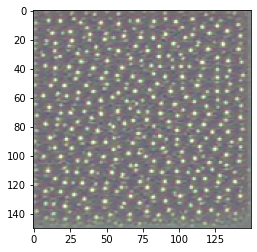

In [41]:
plt.imshow(generate_pattern('block3_conv1', 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


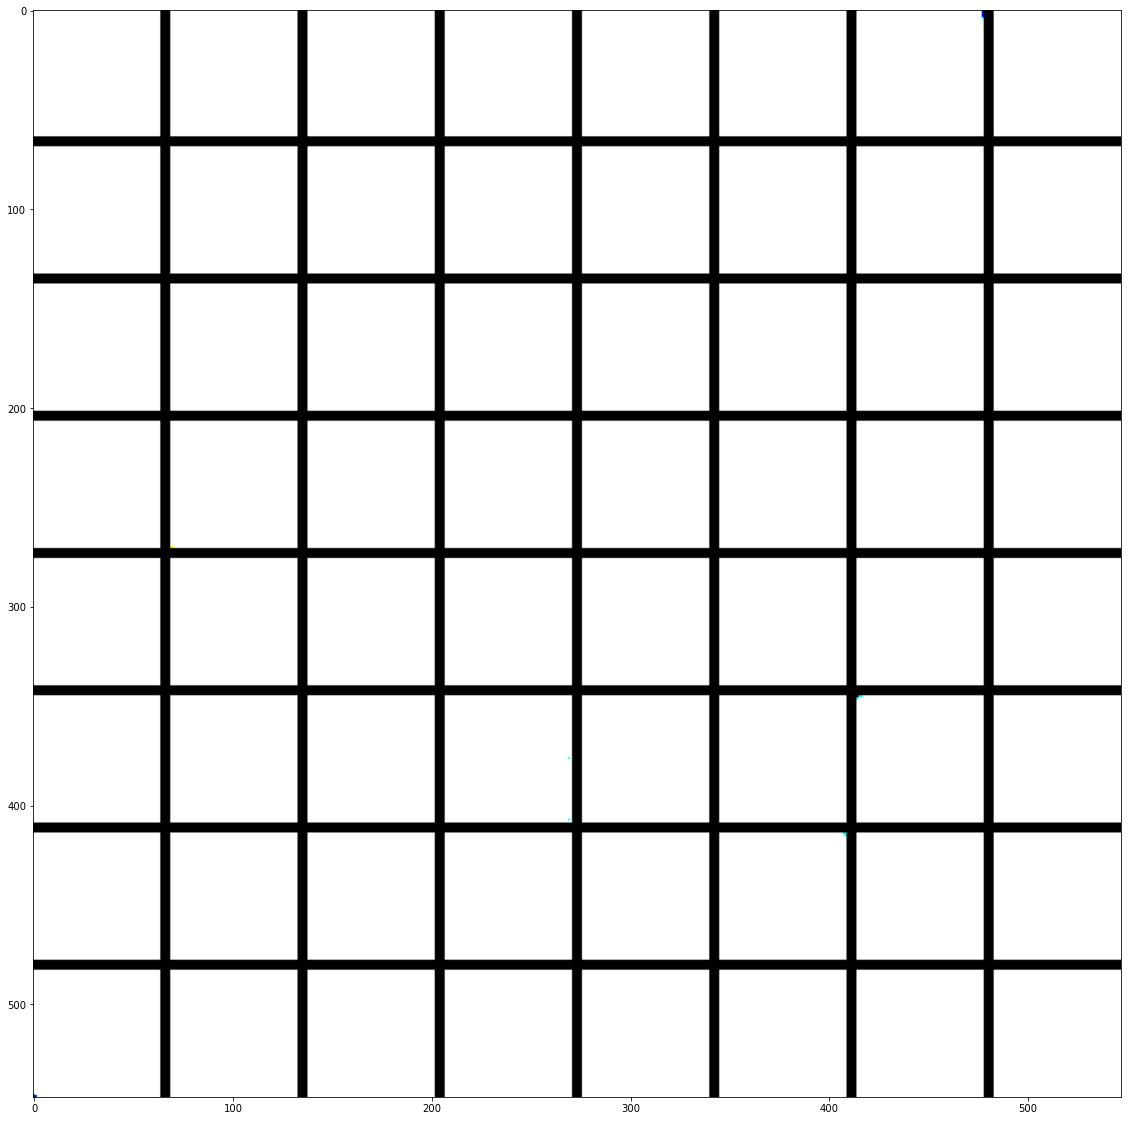

In [47]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

#check the first 64 filters
for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, 
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20,20))
plt.imshow(results)

## Visualizing heatmaps of class activation

understanding which parts of a given image led a convnet to its final classification decision.

This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.

We will use a visualization technique called `class activation map`

方法：

Predicted: [('n02504458', 'African_elephant', 0.8395154), ('n01871265', 'tusker', 0.1483866), ('n02504013', 'Indian_elephant', 0.011430414)]


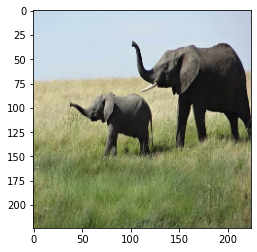

In [53]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

model = VGG16(weights='imagenet') #we use the whole network instead of only convolutional base

img_path ='/Users/zhiruitang/Desktop/Deep_Learning/\
Jupyter_Code_DL/Convolution_neural_networks/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

#float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

#Adds a dimension 
#to transform the array 
#into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

#Preprocesses the batch 
#(this does channel-wise color normalization)
x = preprocess_input(x)

#predict and transform to human-readable format
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process.

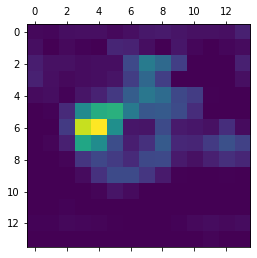

In [59]:
#“African elephant” entry in the prediction vector
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

#Gradient of the “African elephant” class
#with regard to the output feature map of block5_conv3
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

#Vector of shape (512,), 
#where each entry is the mean intensity of the gradient 
#over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)


heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
plt.matshow(heatmap)

In [61]:
#Superimposing the heatmap with the original picture
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img #0.4 here is a heatmap intensity factor.
cv2.imwrite('/Users/zhiruitang/Desktop/Deep_Learning/\
Jupyter_Code_DL/Convolution_neural_networks/elephant_cam.jpg', superimposed_img)

True